<a href="https://colab.research.google.com/github/delemarchand2020/IVADO_MILA_DL/blob/main/week1_tutorial_denis_lemarchand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IVADO-Mila Deep Learning School
# Spring 2021
# Tutorial: Introduction to data processing for machine learning experiments

## Authors: 

Arsène Fansi Tchango <arsene.fansi.tchango@mila.quebec>

Francis Grégoire

Gaétan Marceau Caron <gaetan.marceau.caron@mila.quebec>

# Preface

This tutorial emphasizes the importance of understanding the dataset associated with a machine learning (ML) project. This understanding will help you consider valuable operations to do before training your ML models. It serves as a gentle introduction to data exploration and covers introductory concepts that every machine learning practitioner should know.

**Note: the purpose of this tutorial is to be introductory. Thus, we propose simple solutions to our exercises. In practice, you should use more advanced techniques to train your models.**

# Initialization

Before we begin, we must install all the required libraries for this part of the tutorial. To do so, we will use the `pip` utility. Execute the cell below by selecting it and pressing `shift`+`Enter`. (This operation may take a few minutes.)

We need to be using the latest version of `pillow` for this tutorial. If you are prompted with:

> WARNING: The following packages were previously imported in this runtime:
  [PIL]
You must restart the runtime in order to use newly installed versions.

Then click on restart runtime and rerun the cells afterwards.

In [1]:
!pip3 install torch torchvision matplotlib
!pip3 install --upgrade pillow==8.1.0


Requirement already up-to-date: pillow==8.1.0 in /usr/local/lib/python3.7/dist-packages (8.1.0)


To ensure that all required libraries are available, let's try to load all libraries and modules we will need during this tutorial by executing this cell: 

In [2]:
import importlib
required_libraries = ['torch', 'torchvision', 'PIL', 'matplotlib', 'numpy']
for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        print("%s unavailable" % lib)

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

print("Torch version: ", torch.__version__)
print("GPU Available: {}".format(use_gpu))

Torch version:  1.8.1+cu101
GPU Available: True


Fix the seed for the different libraries

In [4]:
seed = 1234
np.random.seed(seed) # Set the random seed of numpy for the data split.
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Introduction

In this tutorial, we will use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. It is a collection of 32 x 32 color images in 10 different classes. The 10 different (indexed-)classes are the following:
0. airplane;
1. automobile;
2. bird;
3. cat;
4. deer;
5. dog;
6. frog;
7. horse;
8. ship;
9. truck.

The task of interest in this tutorial is an image classification task. We are interested in finding the class associated with a given image. We will use [PyTorch](https://pytorch.org/) as the ML framework.

At this stage, we provide as-is all functions and related PyTorch methods. This tutorial is not about learning PyTorch but instead focuses on understanding data and basic ML concepts. In the following tutorials, you will learn how to develop, train, and evaluate models on different data types.

# Data preparation

## Data retrieval

In this section, we provide a function for downloading the CIFAR-10 dataset. It takes as input two arguments:
- **path**: the directory where the downloaded dataset will be saved.
- **train_flag**: boolean flag indicating whether to download data from the training set (`train_flag=True`) or the test set (`train_flag=False`).

It returns two elements, namely:
- **imgs**: NumPy array representing the downloaded images of size N x 32 x 32 x 3 where N is the number of images.
- **labels**: list of N (indexed-)classes, each associated with a single image.

In [5]:
def download_CIFAR10(path, train_flag):
  """
  Args:
     path: the directory where the dowloaded dataset will be saved.
     train_flag: if `True`, download data from training set, otherwise
        download from test set.
        
  Return:
     A tuple of two elements (imgs, labels) where
        imgs: a numpy array of shape N x 32 x 32 x 3 where N is the number of images.
        labels: list of N (indexed-)classes, each  associated with a single image.
  
  """
  dataset = torchvision.datasets.CIFAR10(
      root=path, train=train_flag, download=True
  )
  imgs, labels = dataset.data, dataset.targets
  return imgs, labels


### Exercise 1

Download the CIFAR-10 dataset and retrieve the training set.

In [6]:
imgs, labels = download_CIFAR10(".", True) # To complete.



Extracting ./cifar-10-python.tar.gz to .


Retrieve the CIFAR-10 test set.

In [7]:
test_imgs, test_labels = download_CIFAR10(".", False) # To complete.

Files already downloaded and verified


## Data split

In the previous section, we provide functions to download the **train** and **test** datasets. Usually, we need three sets of data in a ML project: train, **validation**, and test sets. Unfortunately, the CIFAR-10 dataset does not contain a preprocessed validation set; therefore, we need to create a **custom** one by sampling from the **training** set.

In this section, we provide a function for creating a validation set from the original training set. It takes as input five arguments:
- **imgs**: NumPy array representing the image set from which the partitioning is made.
- **labels**: labels associated with the provided image set.
- **valid_ratio** (optional): a proportion of the data that will be used for the validation set. Default: `0.3`.
- **shuffle** (optional): whether or not the data need to be shuffled before the partitioning is made. Default: `True`.
- **seed** (optional): the seed of the random generator. Default: `1234`.

It provides as output 4 elements, which are:
- **train_imgs**: NumPy array representing the images of the training set after the splitting is done.
- **train_labels**: labels associated with the images of the training set.
- **valid_imgs**: NumPy array representing the images of the validation set after the splitting is done.
- **valid_labels**: labels associated with the images of the validation set.

In [8]:
def partition_dataset(imgs, labels, valid_ratio=0.3, shuffle=True, seed=1234):
  """
  Args:
     imgs: numpy array representing the image set from which 
        the partitioning is made.
     labels: the labels associated with the provided images.
     valid_ratio (optional): the proportion of the data that will be used in
        the validation set. Default: 0.3.
     shuffle (optional): whether or not to shuffle the data. Default: True.
     seed (optional): the seed of the numpy random generator: Default: 1234.
        
  Return:
     A tuple of 4 elements (train_imgs, train_labels, valid_imgs, valid_labels)
     where:
        train_imgs: a numpy array of images for the training set.
        train_labels: labels associated with the images in the training set.
        valid_imgs: a numpy array of images for the validation set.
        valid_labels: labels associated with the images in the validation set.
  
  """
  if shuffle:
    np.random.seed(seed)  # Set the random seed of numpy.
    indices = np.random.permutation(imgs.shape[0])
  else:
    indices = np.arange(imgs.shape[0])
  
  train_idx, valid_idx = np.split(
      indices, 
      [int((1.0 - valid_ratio)*len(indices))]
  )
  train_imgs, valid_imgs = imgs[train_idx], imgs[valid_idx]
  labels = np.array(labels)
  train_labels, valid_labels = labels[train_idx].tolist(), labels[valid_idx].tolist()
  return train_imgs, train_labels, valid_imgs, valid_labels
  

### Exercise 2

Generate the custom training and validation sets by using `partition_dataset` with the default parameters.

In [41]:
train_imgs, train_labels, valid_imgs, valid_labels = partition_dataset(imgs, labels) # To complete.

## Data visualization

Before training any model, you should do some sanity checks of the data to ensure that the retrieval and the split were correctly done.

This section provides some functions for visualizing image data and computing the label distribution within a dataset.

In [10]:
import matplotlib.pyplot as plt


def plot_image(img):
  """
  Plot a single image.
  
  Args:
     img: image to be plotted.
     
  """
  plt.imshow(img)
  plt.show()

 # MODIF DENIS : retourner les indices sélectionnés 
def plot_random_images(imgs, n):  
  """
  Randomly sample n images from an image set and plot them in a grid.
  
  Args:
     imgs: collection of images from which sampling will be made.
     n: the number of images to be sampled.
     
  """
  sampled_indices = np.random.choice(imgs.shape[0], n, False)
  sampled_images = imgs[sampled_indices]
  
  sampled_images = np.transpose(sampled_images, (0, 3, 1, 2))
  sampled_tensor = torch.Tensor(sampled_images)
  
  grid_tensor = torchvision.utils.make_grid(
      sampled_tensor, normalize=True, value_range=(0, 255)
  )
  grid_tensor = np.transpose(grid_tensor.numpy(), (1, 2, 0))
  
  plot_image(grid_tensor)

  return sampled_indices
  
  
def plot_dataset_histogram(labels, title='Label distribution', rel_freq=False):
  """
  Plot the histogram/distribution of the labels within a dataset.
  
  Args:
     labels: collection of labels from which the distribution is computed.
     title: the title of the histogram.
     rel_freq: if true, the histogram is normalized to show relative frequencies
               otherwise, it shows the frequencies.
     
  """
  _ = plt.hist(labels, bins=np.arange(11)-0.5, rwidth=0.85, density=rel_freq)
  plt.title(title)
  plt.xlabel('Label')
  if rel_freq:
    plt.ylabel('Relative frequency')
  else:
    plt.ylabel('Frequency')
  plt.xticks(np.arange(10))
  plt.show()


### Exercise 3

Use the previously defined functions to visualize samples from training and validation sets. Also, compute the label distributions for these two sets. Comment on your observations.

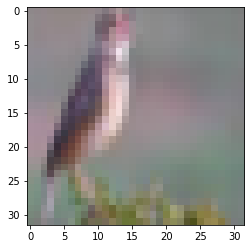

2

In [11]:
# plot a given sample from the training dataset and retrieve its label
img = train_imgs[0]
plot_image(img) # To complete.
train_labels[0]

Observations:
... # To complete.


0. airplane;
1. automobile;
2. bird;
3. cat;
4. deer;
5. dog;
6. frog;
7. horse;
8. ship;
9. truck.

In [12]:
codage_labels = {
 '0': 'airplane',
 '1': 'automobile',
 '2': 'bird',
 '3': 'cat',
 '4': 'deer',
 '5': 'dog',
 '6': 'frog',
 '7': 'horse',
 '8': 'ship',
 '9': 'truck'
}

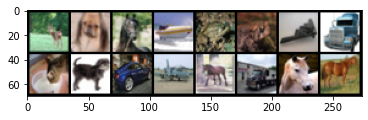

deer dog horse ship frog frog airplane truck cat dog automobile airplane horse truck horse horse 

In [13]:
# plot random samples (e.g. 16) from the training dataset
sampled_indices = plot_random_images(train_imgs,16) # To complete.
sampled_labels = np.array(train_labels)[sampled_indices]
for x in sampled_labels:
  print(codage_labels[str(x)], end=' ')

Observations:
... # To complete.


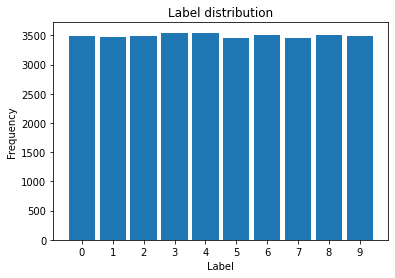

In [14]:
# plot the label distribution of the training dataset
plot_dataset_histogram(train_labels) # To complete.

Observations:
... # To complete.


## Shuffling data

It is essential to **shuffle** the dataset before partitioning it into training, validation and test sets to remove spurious correlations due to the ordering. Remember the dataset should be **independently** and identically distributed.

The CIFAR-10 dataset downloaded at the beginning of this tutorial was already shuffled. To visualize the importance of shuffling, suppose we observe the following label distributions after splitting.

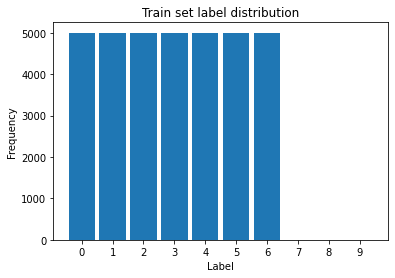

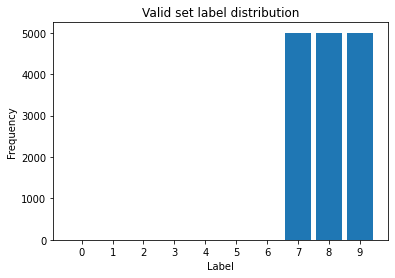

In [15]:
sorted_idx = np.argsort(labels)
sorted_imgs = imgs[sorted_idx]
sorted_labels = [labels[i] for i in sorted_idx]

_, sorted_train_labels, _, sorted_valid_labels = partition_dataset(sorted_imgs, sorted_labels,
                                                                   valid_ratio=0.3, shuffle=False, seed=seed)
plot_dataset_histogram(sorted_train_labels, 'Train set label distribution')
plot_dataset_histogram(sorted_valid_labels, 'Valid set label distribution')

### Exercise 4
What will be the consequences of using these training and validation sets on the performance metrics?

... # To complete.
On apprend sur un jeu de données incomplets (pas uniformément distribué) et on valide sur le complémentaire ... performance nulle


Below, we shuffle the data and observe that the labels are evenly distributed in the training and validation sets.

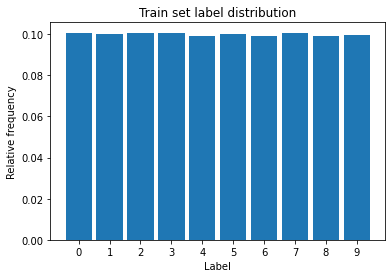

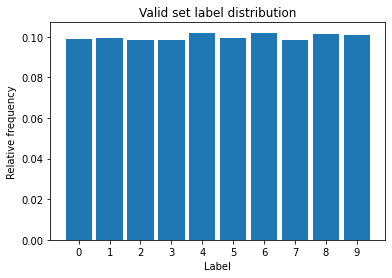

In [16]:
_, shuffled_train_labels, _, shuffled_valid_labels = partition_dataset(
    sorted_imgs, sorted_labels, valid_ratio=0.3, shuffle=True, seed=seed
)

plot_dataset_histogram(
    shuffled_train_labels, 'Train set label distribution', rel_freq=True)

plot_dataset_histogram(
    shuffled_valid_labels, 'Valid set label distribution', rel_freq=True)

## Dataloaders

As you will see in the next tutorials, to train and evaluate models, we use **dataloaders**. Since deep learning requires heavy data transformations, we want tools that efficiently **transform**, **shuffle**, and **batch** our datasets with the option to use multiprocessing workers. A dataloader is an optimized data iterator that provides all these features.

Modern deep learning frameworks, such as PyTorch and TensorFlow, offer very efficient dataloaders out of the box.

We show a simple example of preparing a dataloader using a small subset of our training set. During training, it is recommended to shuffle the data at the beginning of each **epoch** (the process of the entire training set is referred to as an epoch). Thus, we usually set `shuffle=True` for training and `shuffle=False` for evaluation.

In [17]:
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader


def create_dataset(images, labels, n):
  """
  Slice the first n images/labels and create a torch.utils.data.DataLoader.
  
  Args:
     images: numpy array of images.
     labels: list of labels associated with the images.
     n: the number of images/labels to slice.
        
  Return:
     A torch.utils.data.TensorDataset to be used with a torch.utils.data.DataLoader.
     
  """
  imgs = torch.tensor(images[:n], dtype=torch.float)
  labels = torch.tensor(labels[:n], dtype=torch.long)
  dataset = TensorDataset(imgs, labels)
  return dataset


n = 100
batch_size = 32
train_dataset = create_dataset(train_imgs, train_labels, n)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)

epochs = 2
for epoch in range(epochs):
  print('Epoch {}/{}:'.format(epoch+1, epochs))
  for i, (x, y) in enumerate(train_dataloader):
    print('   batch {}/{} of {} examples.'.format(i+1, int(np.ceil(n/batch_size)), y.size(0)))

Epoch 1/2:
   batch 1/4 of 32 examples.
   batch 2/4 of 32 examples.
   batch 3/4 of 32 examples.
   batch 4/4 of 4 examples.
Epoch 2/2:
   batch 1/4 of 32 examples.
   batch 2/4 of 32 examples.
   batch 3/4 of 32 examples.
   batch 4/4 of 4 examples.


Epoch 1/2:
   batch 1/2 of 2 examples.


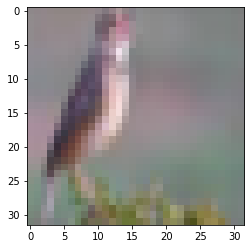

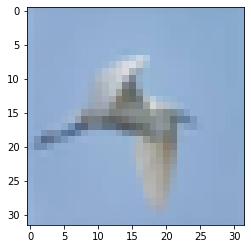

   batch 2/2 of 2 examples.


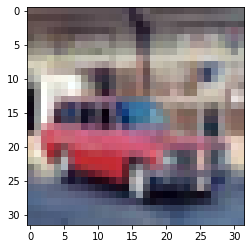

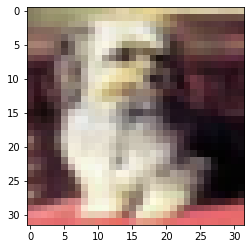

Epoch 2/2:
   batch 1/2 of 2 examples.


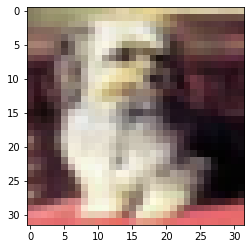

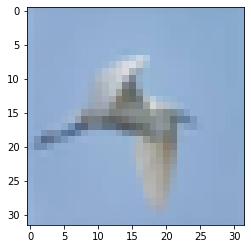

   batch 2/2 of 2 examples.


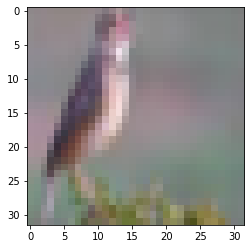

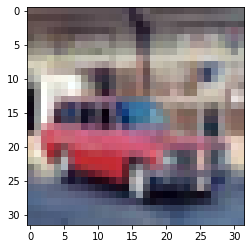

In [18]:
n=4
batch_size=2

train_dataset = create_dataset(train_imgs, train_labels, n)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)

epochs = 2
for epoch in range(epochs):
  print('Epoch {}/{}:'.format(epoch+1, epochs))
  for i, (x, y) in enumerate(train_dataloader):
    print('   batch {}/{} of {} examples.'.format(i+1, int(np.ceil(n/batch_size)), y.size(0)))
    plot_image(x[0].numpy().astype(np.uint8))
    plot_image(x[1].numpy().astype(np.uint8))

Thus, we can easily iterate over the the training set for many epochs with a simple `for` loop. At every iteration of the loop, the dataloader returns a mini-batch of `batch_size` input-label pairs `(x, y)`.

By setting `drop_last=False`, the last incomplete batch is kept if the dataset size is not divisible by `batch_size`. When training a model, we average the loss of the examples of a mini-batch. Having 4 examples in the last mini-batch instead of 32 gives more weight to these 4 examples than the other examples. In practice, if we shuffle the training set at each epoch, we mitigate this bias since different examples will have the chance to be in the last mini-batch.

# Training with neural networks

This section provides two methods for training and evaluating neural networks. We will use these methods for studying the impact of dataset size and unbalanced classes on models' performances. **For this tutorial, we don't need to understand the implementation of these methods.** These will be covered in the following tutorials.

The first method, `training_on_dataset`, trains a model on a given dataset. It takes as input the following arguments and returns a **trained model**:
- **imgs**: images the model will be trained on.
- **labels**: labels associated with the provided images.
- **eval_imgs**: images to evaluate the model.
- **eval_labels**: labels associated with the images used to evaluate the model.
- **epochs**: number of epochs during the training (number of times to loop over the whole set of images/labels).
- **batch_size** (optional): size of a mini-batch. Default: `8`.
- **lr** (optional): learning rate. Default: `1e-3`.
- **seed** (optional): the seed of the random generator. Default: `1234`.
- **transformations** (optional): transformations to apply to the images during the training process. Default: `None`.
- **label_weights** (optional): importance weights associated with each label. Default: `None` (all labels are treated equally).
- **metrics** (optional): metrics to monitor during training. Default: `None`.

The second one, `evaluate_classes`, evaluates a trained model on a given dataset. It takes as input the following arguments and returns the **evaluation performance**:
- **net**: the trained model to be evaluated.
- **imgs**: images the model will be evaluated on.
- **labels**: ground truth labels associated with the provided images for performance computation.
- **batch_size** (optional): size of a mini-batch. Default: `8`.
- **metrics** (optional): performance metrics to compute. Default: `None`.


In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sklearn.metrics as metrics


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
classe_names = (
    'plane', 'car', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck'
)


def accuracy(y_true, y_pred):
  """
  Compute the accuracy score.
  
  Args:
     y_true: ground truth labels.
     y_pred: predicted labels by a classifier.
     
  Return:
     Accuracy score.
     
  """
  return metrics.accuracy_score(y_true, y_pred)


def f1_score(y_true, y_pred):
  """
  Compute the F1 score.
  
  Args:
     y_true: ground truth labels.
     y_pred: predicted labels by a classifier.
     
  Return:
     F1 score.
     
  """
  return metrics.f1_score(y_true, y_pred, average='macro')


def plot_metric(train_values, valid_values, name=''):
  """
  Plot the values of a given metric on training and validation sets.
  
  Args:
     train_values: values of the metric on the training set. 
     valid_values: values of the metric on the validation set.
     name: name of the metric.
  """
  x = range(len(train_values))
  plt.plot(x, train_values, label='train')
  plt.plot(x, valid_values, label='valid')
  plt.title(name)
  plt.legend()
  plt.show()
  

class AugmentBasedDataset(Dataset):
  """Encapsulated dataset for data augmentation."""

  def __init__(self, dataset, transform=None):
    """
    Args:
        dataset: dataset on which to perform data augmentation.
        transform (callable, optional): optional transform to be applied
            on a sample.

    """
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    img, label = self.dataset[idx]
    if self.transform:
        img = self.transform(img)
    return img, label


In [20]:
#@title Class Net
class Net(nn.Module):
  """Basic CNN used for image classification."""
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In the next code block, we implement three functions for training and evaluating the model. In the following exercises, you will need to use only these two functions:

```
training_on_dataset(imgs, labels, eval_imgs, eval_labels,
                    epochs, batch_size=8, lr=1e-3,
                    seed=1234, transformations=None, label_weights=None,
                    metrics=None, verbose=True)
```


```
def evaluate_classes(net, imgs, labels, batch_size=8, metrics=None, verbose=True)
```

Because of the code complexity, we hide their implementation, which you do not need to understand for this tutorial. If you want to look at the code, you can always double-click on the title `Auxiliary functions for training and evaluating the model`. To hide the code, click on the three vertical dots of the code block and then `form -> Hide code`.  In every case, make sure to press the `run` button of the following code block.

In [21]:
#@title Auxiliary functions for training and evaluating the model
def training_on_dataset(imgs, labels, eval_imgs, eval_labels,
                        epochs, batch_size=8, lr=1e-3,
                        seed=1234, transformations=None, label_weights=None,
                        metrics=None, verbose=True):
  """Black box function to train a neural network on CIFAR-10 dataset."""
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  np.random.seed(seed)
  
  # Train data.
  train_imgs = ((imgs/255.0) - 0.5) * 2.0  # Normalize to [-1, 1].
  train_imgs = np.transpose(train_imgs, (0, 3, 1, 2))
  train_labels = np.array(labels)
  
  train_dataset = TensorDataset(
      torch.from_numpy(train_imgs).float(), 
      torch.from_numpy(train_labels).long()
  )
  train_dataset = AugmentBasedDataset(train_dataset, transformations)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  # Eval data.
  eval_imgs = ((eval_imgs/255.0) - 0.5) * 2.0 # Normalize to [-1, 1]
  eval_imgs = np.transpose(eval_imgs, (0, 3, 1, 2))
  eval_labels = np.array(eval_labels)
  
  eval_dataset = TensorDataset(
      torch.from_numpy(eval_imgs).float(), 
      torch.from_numpy(eval_labels).long()
  )
  eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

  net = Net()
  net = net.to(device)
  if label_weights is not None:
    label_weights = torch.tensor(label_weights).float()
    label_weights = label_weights.to(device)
  criterion = nn.CrossEntropyLoss(weight=label_weights)
  optimizer = optim.Adam(net.parameters(), lr=lr)
  
  train_loss_values = []
  eval_loss_values = []
  train_metric_values = None
  eval_metric_values = None
  
  if metrics is not None:
    if isinstance(metrics, dict):
      train_metric_values = {metric: [] for metric in metrics.keys()}
      eval_metric_values = {metric: [] for metric in metrics.keys()}
    elif isinstance(metrics, (list, tuple)):
      train_metric_values = {metric: [] for metric in range(len(metrics))}
      eval_metric_values = {metric: [] for metric in range(len(metrics))}
    else:
      metrics = [metrics]
      train_metric_values = {metric: [] for metric in range(len(metrics))}
      eval_metric_values = {metric: [] for metric in range(len(metrics))}

  for epoch in range(epochs):  # Loop over the dataset.
    net.train()
    running_loss = 0.0
    n_update = 0
    y_true = []
    y_pred = []
    for data in train_dataloader:
      # data is a tuple of (inputs, targets).
      inputs, targets = data
      
      if targets.numel() > 1:
        y_true.extend(targets.flatten().tolist())
      else:
        y_true.append(targets.flatten().tolist())
      
      inputs = inputs.to(device)
      targets = targets.to(device)       

      # Reset the parameter gradients.
      optimizer.zero_grad()

      # Forward + backward + optimize.
      outputs = net(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      
      # Predict label.
      _, predicted = torch.max(outputs, 1)
      if predicted.numel() > 1:
        y_pred.extend(predicted.flatten().tolist())
      else:
        y_pred.append(predicted.flatten().tolist())

      running_loss += loss.item()
      n_update += 1

    # Save and print statistics at the end of each training epoch.
    train_loss = running_loss / n_update
    train_loss_values.append(train_loss)
    eval_loss, eval_true, eval_pred = evaluate_during_training(net, criterion, eval_dataloader)
    eval_loss_values.append(eval_loss)
    
    if metrics is not None:
      for metric in metrics.keys():
        train_metric_values[metric].append(metrics[metric](y_true, y_pred))
        eval_metric_values[metric].append(metrics[metric](eval_true, eval_pred))
  
    if verbose:
      print('[Epoch {}/{}] Training loss: {:.3f} | Validation loss: {:.3f}' 
            .format(epoch + 1, epochs, train_loss, eval_loss)
      )
    running_loss = 0.0
    n_update = 0
    y_true = []
    y_pred = []
  
  if verbose:
    plot_metric(train_loss_values, eval_loss_values, 'Loss')
    if metrics is not None:
      for metric in metrics.keys():
        plot_metric(train_metric_values[metric], eval_metric_values[metric], metric)
  
  return net


def evaluate_during_training(net, criterion, dataloader):
  net.eval()
  running_loss = 0.0
  n_update = 0
  y_true = []
  y_pred = []
  for data in dataloader:
    inputs, targets = data
    if targets.numel() > 1:
      y_true.extend(targets.flatten().tolist())
    else:
      y_true.append(targets.flatten().tolist())
    inputs = inputs.to(device)
    targets = targets.to(device) 
    with torch.no_grad():
      outputs = net(inputs)
      loss = criterion(outputs, targets)  
      _, predicted = torch.max(outputs, 1)
      if predicted.numel() > 1:
        y_pred.extend(predicted.flatten().tolist())
      else:
        y_pred.append(predicted.flatten().tolist())
      running_loss += loss.item()
      n_update += 1
  eval_loss = running_loss / n_update
  return eval_loss, y_true, y_pred


def evaluate_classes(net, imgs, labels, batch_size=8, metrics=None, verbose=True):
  """Black box function to evaluate a neural network on CIFAR-10 dataset."""
  normalized_imgs = ((imgs/255.0) - 0.5) * 2.0 # Normalize to [-1, 1]
  normalized_imgs = np.transpose(normalized_imgs, (0, 3, 1, 2))
  arr_labels = np.array(labels)
  
  dataset = TensorDataset(
      torch.from_numpy(normalized_imgs).float(), 
      torch.from_numpy(arr_labels).long()
  )
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
  
  net = net.to(device)
  correct = 0
  total = 0
  class_correct = [0.0] * 10
  class_total = [0.0] * 10
  class_acc = [0.0] * 10
  
  metric_values = None
  if not (metrics is None):
    if isinstance(metrics, dict):
      metric_values = {a: 0.0 for a in metrics.keys()}
    elif isinstance(metrics, (list, tuple)):
      metric_values = {a: 0.0 for a in range(len(metrics))}
    else:
      metrics = [metrics]
      metric_values = {a: 0.0 for a in range(len(metrics))}
  
  with torch.no_grad():
    y_true = []
    y_pred = []
    for data in dataloader:
      inputs, targets = data
      
      if targets.numel() > 1:
        y_true.extend(targets.flatten().tolist())
      else:
        y_true.append(targets.flatten().tolist())
        
      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      
      if predicted.numel()>1:
        y_pred.extend(predicted.flatten().tolist())
      else:
        y_pred.append(predicted.flatten().tolist())
      
      total += targets.size(0)
      correct += (predicted == targets).sum().item()
      
      c = (predicted == targets).squeeze()
      for i in range(targets.size(0)):
        label = targets[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
            
    if not (metric_values is None):
      for a in metric_values.keys():
        metric_values[a] = metrics[a](y_true, y_pred)
            
  global_acc = correct / max(total, 1.0)
  
  if verbose:
    if metrics is not None:
      print('Evaluation on the validation dataset:')
      for a in metric_values.keys():
        print('Metric {}: {:.0%}'.format(a, metric_values[a]))

  for i in range(10):
    class_acc[i] = class_correct[i] / max(class_total[i], 1.0)
    if verbose:
      print('Accuracy of {:<5s} ({}): {:.0%}'
            .format(classe_names[i], i, class_acc[i])
           )
    
  return global_acc, class_acc


# How much training data is needed?



In this section, we study the effect of the training set size on models' performances. We also use a technique called **data augmentation** to artificially create variants of examples with synthetic transformations.

Note that we keep the validation set fixed throughout this section. This is just for the purpose of this tutorial, as we want the different evaluations to be comparable. In practice, the validation dataset should never be larger than the training dataset.

## Training with only 1% of the data

Let's start by considering only 1% of the training set. The following method allows selecting a subset of data from a given dataset. It takes as input five arguments:
- **imgs**: NumPy array representing the image set from which the selection is made.
- **labels**: labels associated with the provided image set.
- **ratio** (optional): percentage of data that will be selected. Default: `0.1`.
- **shuffle** (optional): whether or not the data need to be shuffled before the selection is made. Default: `True`.
- **seed** (optional): seed of the random generator: Default: `1234`.

It provides as output 2 elements:
- **select_imgs**: NumPy array of the selected images.
- **select_labels**: labels associated with the selected images.

In [22]:
def select_subset_from_dataset(imgs, labels, ratio=0.1, shuffle=True, seed=1234):
  """
  Args:
     imgs: numpy array representing the image set from which 
        the selection is made.
     labels: the labels associated with the provided images.
     ratio (optional): percentage of data to be selected. Default: 0.1.
     shuffle (optional): Whether or not to shuffle the data. Default: True.
     seed (optional): seed of the numpy random generator: Default: 1234.
        
  Return:
     A tuple of 2 elements (select_imgs, select_labels)
     where:
        select_imgs: a numpy array of the selected images.
        select_labels: labels associated with the selected images.
      
  """
  if shuffle:
    np.random.seed(seed)  # Set the random seed of numpy.
    indices = np.random.permutation(imgs.shape[0])
  else:
    indices = np.arange(imgs.shape[0])
  idx, _ = np.split(indices, [int(ratio*len(indices))])
  select_imgs = imgs[idx]
  labels = np.array(labels)
  select_labels = labels[idx].tolist()
  return select_imgs, select_labels

In [23]:
print(train_imgs.shape)

(35000, 32, 32, 3)


We create a new training set that contains only 1% of the original training set.

In [24]:
train_1percent_imgs, train_1percent_labels  = select_subset_from_dataset(
    train_imgs, train_labels, ratio=0.01
)

### Exercise 5

Train a model on 1% of the training set and evaluate its performance on the validation set. Use the following values for this experiment:
- **epochs**: `50`.
- **batch_size**: `32`.
- **metrics**: `{'Accuracy': accuracy}`.
- **eval_imgs**: `valid_imgs`.
- **eval_labels**: `valid_labels`.

What do you observe?

[Epoch 1/50] Training loss: 2.306 | Validation loss: 2.282
[Epoch 2/50] Training loss: 2.254 | Validation loss: 2.223
[Epoch 3/50] Training loss: 2.172 | Validation loss: 2.151
[Epoch 4/50] Training loss: 2.077 | Validation loss: 2.083
[Epoch 5/50] Training loss: 1.995 | Validation loss: 2.071
[Epoch 6/50] Training loss: 1.936 | Validation loss: 2.058
[Epoch 7/50] Training loss: 1.871 | Validation loss: 2.055
[Epoch 8/50] Training loss: 1.815 | Validation loss: 2.004
[Epoch 9/50] Training loss: 1.776 | Validation loss: 2.053
[Epoch 10/50] Training loss: 1.706 | Validation loss: 2.062
[Epoch 11/50] Training loss: 1.684 | Validation loss: 2.073
[Epoch 12/50] Training loss: 1.618 | Validation loss: 2.055
[Epoch 13/50] Training loss: 1.543 | Validation loss: 2.097
[Epoch 14/50] Training loss: 1.491 | Validation loss: 2.051
[Epoch 15/50] Training loss: 1.423 | Validation loss: 2.129
[Epoch 16/50] Training loss: 1.341 | Validation loss: 2.099
[Epoch 17/50] Training loss: 1.287 | Validation l

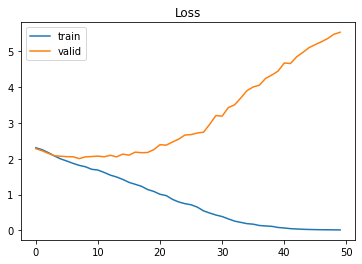

Evaluation on the validation dataset:
Metric Accuracy: 29%
Accuracy of plane (0): 43%
Accuracy of car   (1): 35%
Accuracy of bird  (2): 21%
Accuracy of cat   (3): 30%
Accuracy of deer  (4): 28%
Accuracy of dog   (5): 19%
Accuracy of frog  (6): 31%
Accuracy of horse (7): 32%
Accuracy of ship  (8): 25%
Accuracy of truck (9): 31%


In [25]:
# training on selected data
model = training_on_dataset(train_1percent_imgs, train_1percent_labels, 
                    valid_imgs, valid_labels,
                    50, batch_size=32, lr=1e-3,
                    seed=1234, transformations=None, label_weights=None,
                    metrics=None, verbose=True)

# evaluate the trained model on the validation dataset
_ = evaluate_classes(model, valid_imgs, valid_labels, batch_size=32, 
                     metrics={'Accuracy': accuracy}, verbose=True) # To complete.


On observe le phénomène dans le quizz fin de module 1

## Performance as a function of the dataset size

In the following, We train the same model on various ratios of the training set while keeping the validation set fixed. We want to observe the impact of using larger training sets.

The following function performs this study given a list of ratio values. It takes as arguments:
- **ratio_list**: list of ratio numbers to be considered in the study.
- **epochs** (optional): number of training epochs. Default: `5`.
- **seed** (optional): seed of the random generator: Default: `1234`.

This function generates a plot showing the accuracy as a function of the ratio of data used for training the model.

It is important to note that by fixing the number of epochs, we perform more parameter updates as the training set's size increases. Hence, the overall study is not entirely comparable. However, since the accuracy does not decrease over time in this example, we can still observe the typical phenomenon associated with increasing the training set sizes.

In [26]:
def performance_study(ratio_list, epochs=5, seed=1234):
  """
  Args:
     ratio_list: list of ratio numbers to be considered.
     epochs (optional): number of training epochs. Default: 5.
     seed (optional): seed of the numpy random generator: Default: 1234.
        
  Return:
     This method does not return anything, but it generates a plot.
      
  """
  results = []
  for ratio in ratio_list:
    select_imgs, select_labels = select_subset_from_dataset(
        train_imgs, train_labels, ratio
    )
    trained_model = training_on_dataset(
        select_imgs, select_labels, valid_imgs, valid_labels,
        epochs=epochs, batch_size=32,
        seed=seed, verbose=False
    )
    acc, _ = evaluate_classes(
        trained_model, valid_imgs, valid_labels, batch_size=32,
        verbose=False
    )
    results.append(acc)
  
  print('Best accuracy: {:.0%}'.format(max(results)))
  plt.plot(ratio_list, results)
  plt.title('Model performance on validation set')
  plt.xlabel('Training set ratio')
  plt.ylabel('Accuracy')
  plt.show()


### Exercise 6

Evaluate the performance using the following ratios: `0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0`. 

You can choose the number of epochs you wish for this study. Just have in mind that the higher the number, the longer the time required for the training/study. Therefore, it is recommended to not exceed `epochs=20` for the purpose of this tutorial. As a default, it is set to `epochs=5`.

Again, by having a fixed number of epochs, the larger the training set, the more often we update the model's parameters.

What do you conclude?

Best accuracy: 59%


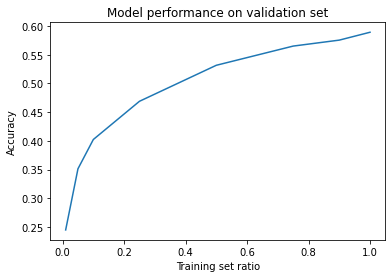

In [27]:
ratio_list = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
performance_study(ratio_list, epochs=5, seed=1234) # To complete.


... # To complete.


## Data augmentation

This section covers data augmentation, which consists of altering the inputs in the training set without changing the associated labels. By doing so, it is possible to augment the number of images in our training set artificially. For example, we can use flipping, cropping, and resizing to alter an image without modifying its associated label. As a result, we may observe some performance gains and better model generalization by learning to be invariant to these transformations. However, since data augmentation is creating artificially new examples from existing ones, the independence assumption is not fully respected. Thus, we should not use data augmentation for the validation and the test sets.

### Exercise 7

Assume that we only have access to 30% of the original training dataset. Train a model with this subset of data and evaluate it on the validation dataset. As the number of examples increases in the training set, we may consider increasing the number of epochs while keeping in mind the overfitting problem. For this exercise, we will use the following arguments:
- **epochs**: `15`.
- **batch_size**: `32`.
- **metrics**: `{'Accuracy': accuracy}`.

In [28]:
# select the data
train_30percent_imgs, train_30percent_labels = select_subset_from_dataset(
    train_imgs, train_labels, ratio=0.3
)

# train on the selected data
model = training_on_dataset(
        train_30percent_imgs, train_30percent_labels, valid_imgs, valid_labels,
        epochs=15, batch_size=32,
        seed=seed, verbose=False
    )

In [29]:
# evaluate on the validation dataset
_ = evaluate_classes(
        model, valid_imgs, valid_labels, batch_size=32,
        verbose=True,metrics={'Accuracy': accuracy}
    )

Evaluation on the validation dataset:
Metric Accuracy: 51%
Accuracy of plane (0): 45%
Accuracy of car   (1): 64%
Accuracy of bird  (2): 29%
Accuracy of cat   (3): 37%
Accuracy of deer  (4): 44%
Accuracy of dog   (5): 36%
Accuracy of frog  (6): 60%
Accuracy of horse (7): 62%
Accuracy of ship  (8): 62%
Accuracy of truck (9): 67%


---
The following code defines a transformation pipeline using the torchvision utilities. The `RandomResizedCrop` operation takes a random crop of the image with a relative size between 0.7 and 1.0. Then, this crop is resized to a 32 x 32 image. The transformations are applied to the original images at every mini-batch generation leaving the dataset's images unchanged; only the mini-batch images are copied and transformed at every iteration.

In [30]:
transformations = transforms.Compose([
    transforms.Normalize((-1, -1, -1), (2, 2, 2)),
    transforms.ToPILImage(),
    transforms.RandomResizedCrop((32, 32), scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Here is an example of applying the data augmentation pipeline to an image. If the images are very similar, rerun the code block to see different random crops.

Original image


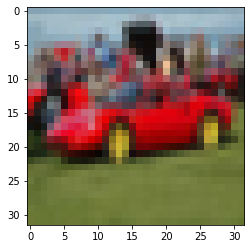

Augmented image


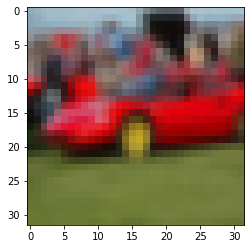

In [31]:
i = 20
img = train_30percent_imgs[i]

# The image needs to be in range [-1 ; 1] with order CxHxW 
# for the transforms
img = np.transpose(img, (2, 0, 1))
img = ((img/255.0) - 0.5) * 2.0
img = torch.as_tensor(img)

aug_img = transformations(img).numpy()

# The image needs to be in range [0 ; 255] with order HxWxC
# for the visualization
aug_img = np.transpose(aug_img, (1, 2, 0))
aug_img = ((aug_img + 1)/2. *255).astype(int)

print('Original image')
plot_image(train_30percent_imgs[i])
print('Augmented image')
plot_image(aug_img)


### Exercise 8
Now, we train a new model by applying data augmentation to the same training set used in the previous exercise. Use the following arguments:
- **epochs**: `25`. DLM : pour comparer 15 ?
- **batch_size**: `32`.
- **metrics**: `{'Accuracy': accuracy}`.

and the argument `transformations` of the `training_on_dataset` method to perform data augmentation during training.

Evaluate your model and compare your results with those from the previous exercise. What do you observe?

In [32]:
# training on selected data with data augmentation techniques
model_aug = training_on_dataset(
        train_30percent_imgs, train_30percent_labels, valid_imgs, valid_labels,
        epochs=15, batch_size=32,
        seed=seed, verbose=False, transformations=transformations
    )

In [33]:
# evaluate on the validation dataset : 
# précédement sans data augmentation on avait 51%
# désormais on obtient 53%
# avec epochs = 25 on passe à 56% !
_ = evaluate_classes(
        model_aug, valid_imgs, valid_labels, batch_size=32,
        verbose=True, metrics={'Accuracy': accuracy}
    )

Evaluation on the validation dataset:
Metric Accuracy: 53%
Accuracy of plane (0): 51%
Accuracy of car   (1): 69%
Accuracy of bird  (2): 28%
Accuracy of cat   (3): 26%
Accuracy of deer  (4): 45%
Accuracy of dog   (5): 57%
Accuracy of frog  (6): 53%
Accuracy of horse (7): 72%
Accuracy of ship  (8): 62%
Accuracy of truck (9): 65%


... # To complete.


# Unbalanced datasets

## What is an unbalanced dataset?

Up to now, the training dataset contained about the same number of images for each label. This section explores the impact of training models on an unbalanced dataset, which happens when each class does not make up an equal subset of your dataset. 

The following function selects a subset of data from a given dataset while providing a defined label distribution. It takes as input six arguments:
- **imgs**: NumPy array representing the image set from which the selection is made.
- **labels**: labels associated with the provided image set.
- **label_dist**: the distribution of labels to be selected, represented by a dict of `{label: value}`.
- **ratio** (optional): percentage of the data that will be selected. Default: `0.1`.
- **shuffle** (optional): whether or not the data need to be shuffled before the selection is made. Default: `True`.
- **seed** (optional): seed of the random generator: Default: `1234`.

It provides as output 2 elements:
- **select_imgs**: a NumPy array of the selected images.
- **select_labels**: labels associated with the selected images.

In [34]:
def select_subset_from_dataset_with_label_dist(
    imgs, labels, label_dist, ratio=0.1, shuffle=True, seed=1234):
  """
  Args:
     imgs: numpy array representing the image set from which 
        the selection is made.
     labels: the labels associated with the provided images.
     label_dist: the distribution of labels to select.
     ratio (optional): percentage of the data to be selected. Default: 0.1.
     shuffle (optional): Whether or not to shuffle the data. Default: True.
     seed (optional): seed of the numpy random generator: Default: 1234.
        
  Return:
     A tuple of 2 elements (select_imgs, select_labels)
     where:
        select_imgs: a numpy array of the selected images.
        select_labels: labels associated with the selected images.
      
  """
  if isinstance(label_dist, (list, tuple)):
    label_dist = {a:v for a,v in enumerate(label_dist)}
  sum_dist = sum(label_dist.values())
  for lab in label_dist.keys():
    label_dist[lab] /= sum_dist
    
  labels = np.array(labels)
  num_indices = int(ratio*len(labels))
  num_idx_lab = {a: int(label_dist[a]*num_indices) for a in label_dist.keys()}
  
  sel_ind = []
  
  if shuffle:
    np.random.seed(seed)  # Set the random seed of numpy.

  for a in num_idx_lab.keys():
    idx = np.where(labels==a)
    idx = idx[0]
    if shuffle:
      idx = np.random.permutation(idx)
    num = min(num_idx_lab[a], len(idx))
    idx = idx[0:num]
    sel_ind.extend(idx)
    
  if shuffle:
    sel_ind = np.random.permutation(sel_ind)
  else:
    sel_ind.sort()
    sel_ind = np.array(sel_ind)
    
  select_imgs = imgs[sel_ind, :]
  select_labels = labels[sel_ind].tolist()
  
  return select_imgs, select_labels


### Exercise 9

Using the function `select_subset_from_dataset_with_label_dist`, extract 30% of the training set with the label distribution defined in the code.

Also, extract 40% of the validation set with the same label distribution.

Compute the histograms of the resulting datasets and compare their relative frequencies.

Note that the relative frequencies may not be exactly equal to the label distribution but should be close enough for our purposes.

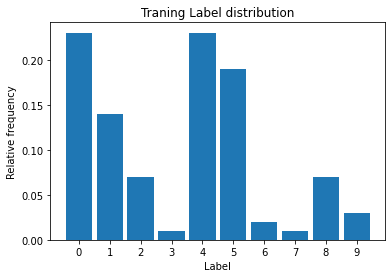

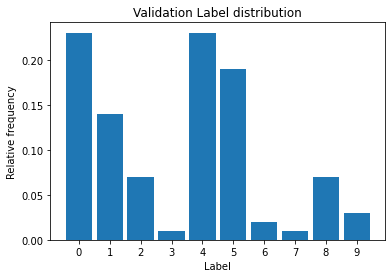

In [35]:
label_distribution = {
    0: 0.23,
    1: 0.14,
    2: 0.07,
    3: 0.01,
    4: 0.23, 
    5: 0.19,
    6: 0.02,
    7: 0.01,
    8: 0.07,
    9: 0.03
}

# select data according to a provided distribution
unbalanced_training_imgs, unbalanced_training_labels = select_subset_from_dataset_with_label_dist(
    train_imgs, train_labels, label_distribution, ratio=0.3, shuffle=True, seed=1234)

# plot the histogram of the selected labels
_ = plot_dataset_histogram(unbalanced_training_labels,
                           title='Traning Label distribution',rel_freq=True) # To complete.

# select data according to a provided distribution
unbalanced_validation_imgs, unbalanced_validation_labels = select_subset_from_dataset_with_label_dist(
    valid_imgs, valid_labels, label_distribution, ratio=0.4, shuffle=True, seed=1234)

# plot the histogram of the selected labels
_ = plot_dataset_histogram(unbalanced_validation_labels,
                           title='Validation Label distribution',rel_freq=True) # To complete.

## Is accuracy a good metric for an unbalanced dataset?

### Exercise 10

Train a model using the unbalanced traning set and evaluate its performance on the unbalanced validation set. Use the following arguments:
- **epochs**: `20`.
- **batch_size**: `32`.
- **metrics**: `{'Accuracy': accuracy, 'F1': f1_score}`.

When we have an unbalanced dataset, using the [F1-score](https://en.wikipedia.org/wiki/F-score) is usually recommended. The F1-score is the harmonic mean of the [Precision and Recall scores](https://en.wikipedia.org/wiki/Precision_and_recall).

Compare the global accuracy with the accuracies per class. What do you observe? What does the F1-score evaluate better than the accuracy in this case?

In [36]:
# training on selected data
modelUnbal = training_on_dataset(unbalanced_training_imgs,unbalanced_training_labels,
              unbalanced_validation_imgs,unbalanced_validation_labels,
              epochs=20,batch_size=32,metrics={'Accuracy': accuracy, 'F1': f1_score},
              verbose=False) # To complete.

# evaluate on the validation dataset
global_acc, class_acc = evaluate_classes(
        modelUnbal, unbalanced_validation_imgs, unbalanced_validation_labels, batch_size=32,
        verbose=True, metrics={'Accuracy': accuracy, 'F1': f1_score}
    )# To complete.


Evaluation on the validation dataset:
Metric Accuracy: 63%
Metric F1: 43%
Accuracy of plane (0): 79%
Accuracy of car   (1): 83%
Accuracy of bird  (2): 23%
Accuracy of cat   (3): 0%
Accuracy of deer  (4): 60%
Accuracy of dog   (5): 71%
Accuracy of frog  (6): 18%
Accuracy of horse (7): 17%
Accuracy of ship  (8): 43%
Accuracy of truck (9): 26%


... # To complete.


## Dealing with unbalanced datasets

One way to mitigate the consequences of an unbalanced dataset during the training process is to penalize the model more when it makes prediction errors on less frequent classes. A way to achieve this is to assign importance weights to examples. Importance weights are the inverse relative frequency of their class within the dataset.

### Exercise 11

Compute the importance weights of each label using the label distribution provided in the previous section.

In [37]:
label_weights = 1/np.array([l for l in label_distribution.values()]) # To complete.

for i, w in enumerate(label_weights):
  print('Importance weight for {:<5s} ({}): {:.1f}'.format(classe_names[i], i, w))

Importance weight for plane (0): 4.3
Importance weight for car   (1): 7.1
Importance weight for bird  (2): 14.3
Importance weight for cat   (3): 100.0
Importance weight for deer  (4): 4.3
Importance weight for dog   (5): 5.3
Importance weight for frog  (6): 50.0
Importance weight for horse (7): 100.0
Importance weight for ship  (8): 14.3
Importance weight for truck (9): 33.3


In [38]:
print([l for l in label_distribution.values()])
print(label_weights)

[0.22999999999999998, 0.14, 0.07, 0.01, 0.22999999999999998, 0.18999999999999997, 0.02, 0.01, 0.07, 0.029999999999999995]
[  4.34782609   7.14285714  14.28571429 100.           4.34782609
   5.26315789  50.         100.          14.28571429  33.33333333]


### Exercise 12

Using the importance weights computed above, train a model using the extracted training dataset and evaluate its performance on the original validation dataset. For the sake of fair comparisons, use the same arguments as in the previous exercise:
- **epochs**: `15`. DLM : pourquoi pas 20 comme utilisé précédement ?
- **batch_size**: `32`.
- **metrics**: `{'Accuracy': accuracy, 'F1': f1_score}`.

Note that the importance weights can be passed to the training method using the argument `label_weights`.

What do you observe?


In [39]:
# training on selected data
modelUnbal = training_on_dataset(unbalanced_training_imgs,unbalanced_training_labels,
              unbalanced_validation_imgs,unbalanced_validation_labels,
              epochs=20,batch_size=32,metrics={'Accuracy': accuracy, 'F1': f1_score}
              ,label_weights=label_weights, verbose=False) # To complete.

# evaluate on the validation dataset
global_acc_weighted, class_acc_weighted = evaluate_classes(
        modelUnbal, unbalanced_validation_imgs, unbalanced_validation_labels, batch_size=32,
        verbose=True, metrics={'Accuracy': accuracy, 'F1': f1_score}
    )# To complete.


Evaluation on the validation dataset:
Metric Accuracy: 57%
Metric F1: 42%
Accuracy of plane (0): 65%
Accuracy of car   (1): 65%
Accuracy of bird  (2): 31%
Accuracy of cat   (3): 12%
Accuracy of deer  (4): 65%
Accuracy of dog   (5): 55%
Accuracy of frog  (6): 28%
Accuracy of horse (7): 27%
Accuracy of ship  (8): 50%
Accuracy of truck (9): 36%


In [40]:
#compare
for i in range(10):
  print('Accuracy of {:<5s} ({}) (relative freq {:.2f}): {:.2f} but with importance weight {:.2f}'.format(classe_names[i], 
      i, [l for l in label_distribution.values()][i],class_acc[i], class_acc_weighted[i]))

Accuracy of plane (0) (relative freq 0.23): 0.79 but with importance weight 0.65
Accuracy of car   (1) (relative freq 0.14): 0.83 but with importance weight 0.65
Accuracy of bird  (2) (relative freq 0.07): 0.23 but with importance weight 0.31
Accuracy of cat   (3) (relative freq 0.01): 0.00 but with importance weight 0.12
Accuracy of deer  (4) (relative freq 0.23): 0.60 but with importance weight 0.65
Accuracy of dog   (5) (relative freq 0.19): 0.71 but with importance weight 0.55
Accuracy of frog  (6) (relative freq 0.02): 0.17 but with importance weight 0.28
Accuracy of horse (7) (relative freq 0.01): 0.17 but with importance weight 0.27
Accuracy of ship  (8) (relative freq 0.07): 0.43 but with importance weight 0.50
Accuracy of truck (9) (relative freq 0.03): 0.26 but with importance weight 0.36


... # To complete.


# Reproducibility

We have seen that there is randomness in machine learning experiments, precisely when:
- splitting an original dataset into training/validation/test sets.
- initializing the parameters of a model.
- shuffling the training set after each epoch when training the model.

Therefore, we usually get different results each time we run the same experiment. It is required to fix the **random seed** at the very beginning of your experiment. Hence, it is best practice to manually set:

1. Python pseudorandom number generator at a fixed value:
```python
import random
random.seed(seed_value)
```

2. NumPy pseudorandom number generator at a fixed value:
```python
import numpy as np
np.random.seed(seed_value)
```

3. PyTorch pseudorandom number generator at a fixed value for all devices (both CPU and GPU):
```python
import torch
torch.manual_seed(seed_value)
```

4. PyTorch pseudorandom number generator at a fixed value for the GPU(s):
```python
import torch
torch.cuda.manual_seed(seed_value)  # Current GPU.
torch.cuda.manual_seed_all(seed_value)  # All GPUs.
```

5. CuDNN algorithms (an extension of CUDA for deep learning) to be deterministic in PyTorch:
```python
import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
```

Note that deterministic algorithms can make computations dramatically slower. This flag should be used only when debugging. 

While manually fixing random seeds helps reproducibility, completely reproducible results are not guaranteed across PyTorch releases and different platforms, devices, or drivers. You should always verify the results of some test experiments when updating your environment.

Furthermore, more randomness comes in when doing hyperparameter tuning or using multiple GPU devices in parallel, but that's beyond the scope of this tutorial.

Finally, a good practice, implemented in Scikit-Learn, is to create a local RandomState object instead of using the global RandomState object and to pass it to every module using randomness. However, the Pytorch API does not allow it, and for now, using global RNGs is recommended.

# Essai Denis

In [92]:
# select the data
train_dlm_imgs, train_dlm_labels = select_subset_from_dataset(
    train_imgs, train_labels, ratio=1
)

# train on the selected data
model = training_on_dataset(
        train_dlm_imgs, train_dlm_labels, valid_imgs, valid_labels,
        epochs=20, batch_size=32,
        seed=seed, verbose=False
    )

In [363]:
def test_predict(model, test_imgs, test_labels, codage_labels, verbose=True):
  """
  test of model prediction 
  on one image randomly selected in the images set provided 
  
  Args:
     model: trained model.
     test_imgs: set of images
     test_labels: set of labels associated to each image
     codage_labels: labels names
     verbose: flag to output plot and logs

  return: 
    true or false if predicted succed or fail
    predicted label id
  """
  n = np.random.randint(0,test_imgs.shape[0])

  one_image = test_imgs[n:n+1]
  one_label = test_labels[n:n+1]

  if verbose == True:
    plot_image(one_image[0])
    print('real label of image {} = {}'.format(n,codage_labels[str(one_label[0])]))

  x = torch.from_numpy(one_image)
  x = x.permute(0, 3, 1, 2)

  # Convert to FloatTensor first
  x = x.type(torch.FloatTensor)
  # Then call cuda() on test_tensor
  x = x.cuda()

  outputs = model(x)
  _, predicted = torch.max(outputs, 1)

  if verbose == True:
    print('predicted label of image {} = {}'.format(n,codage_labels[str(predicted.tolist()[0])]))

  return one_label == predicted.tolist(), predicted.tolist()[0]

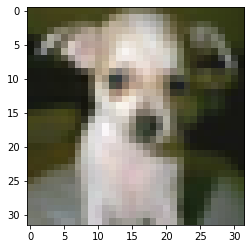

real label of image 7540 = dog
predicted label of image 7540 = dog


(True, 5)

In [367]:
test_predict(model, test_imgs, test_labels, codage_labels, verbose=True)

taux de succes = 0.427


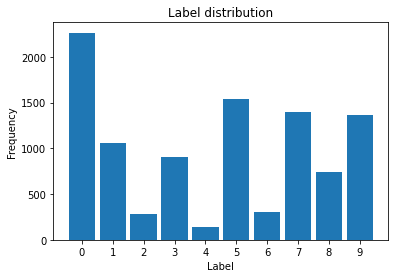

In [368]:
seed = 24345
np.random.seed(seed) # Set the random seed of numpy for the data split.
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
import random
random.seed(seed)

count_success = 0
predicted_labels = np.array([])

nb_test = 10000
for i in range(nb_test):
   success, cat = test_predict(model, test_imgs, test_labels, codage_labels, verbose=False)
   count_success = count_success + success
   predicted_labels = np.append(predicted_labels, np.array([cat]))

ratio_success = count_success/nb_test

print('taux de succes = ' + str(ratio_success))

plot_dataset_histogram(predicted_labels)

seed = 1234
np.random.seed(seed) # Set the random seed of numpy for the data split.
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

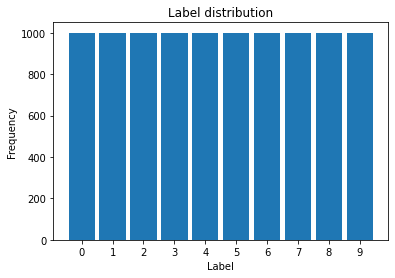

Evaluation on the validation dataset:
Metric Accuracy: 60%
Metric F1: 60%
Accuracy of plane (0): 67%
Accuracy of car   (1): 68%
Accuracy of bird  (2): 49%
Accuracy of cat   (3): 42%
Accuracy of deer  (4): 53%
Accuracy of dog   (5): 51%
Accuracy of frog  (6): 71%
Accuracy of horse (7): 62%
Accuracy of ship  (8): 69%
Accuracy of truck (9): 67%


In [290]:
n = 10000
some_images = test_imgs[:n]
some_labels = test_labels[:n]

plot_dataset_histogram(some_labels)

# evaluate on the validation dataset
_ = evaluate_classes(
        model, some_images, some_labels, batch_size=32,
        verbose=True,metrics={'Accuracy': accuracy, 'F1': f1_score}
    )